In [20]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import scipy.optimize as spop

In [21]:
ticker = '^GSPC'
start = '2020-01-01'
end = '2021-06-25'

In [22]:
prices = yf.download(ticker, start, end)['Close']

[*********************100%***********************]  1 of 1 completed


In [32]:
#Divide array from 2nd to Last day by array from 1st to the penultimate date
returns = np.array(prices)[1:]/np.array(prices)[:-1] - 1

In [37]:
#Parameters
mean = np.average(returns)
var = np.std(returns)**2

In [39]:
def garch_mle(params):
    mu = params[0]
    omega = params[1]
    alpha = params[2]
    beta = params[3]
    
    #long-run volatility
    long_run = (omega/(1- alpha - beta))**(1/2)
    
    #realized and conditional volatility
    resid = returns - mu
    realized = abs(resid)

    conditional = np.zeros(len(returns))
    conditional[0] = long_run
    for t in range(1, len(returns)):
        conditional[t] = (omega + alpha*resid[t-1]**2 + beta*conditional[t-1]**2)**(1/2)
    
    #log-likelihood
    likelihood = 1/((2*np.pi)**(1/2)*conditional) * np.exp(-realized**2/(2*conditional**2))
    log_likelihood = np.sum(np.log(likelihood))
    return -log_likelihood

In [40]:
#maximize log-likelihood, minimize negative = maximize positive
res = spop.minimize(garch_mle, [mean, var, 0, 0], method='Nelder-Mead')

<ipython-input-39-682f1f78baf6>:17: RuntimeWarning: invalid value encountered in double_scalars
  conditional[t] = (omega + alpha*resid[t-1]**2 + beta*conditional[t-1]**2)**(1/2)
<ipython-input-39-682f1f78baf6>:8: RuntimeWarning: invalid value encountered in double_scalars
  long_run = (omega/(1- alpha - beta))**(1/2)


In [41]:
#retrieve optimal parameters
params = res.x
mu = res.x[0]
omega = res.x[1]
alpha = res.x[2]
beta = res.x[3]
log_likelihood = -float(res.fun)

In [42]:
#Calculating realized and conditional volatility (prev)
#long-run volatility
long_run = (omega/(1- alpha - beta))**(1/2)

#realized and conditional volatility
resid = returns - mu
realized = abs(resid)

conditional = np.zeros(len(returns))
conditional[0] = long_run
for t in range(1, len(returns)):
    conditional[t] = (omega + alpha*resid[t-1]**2 + beta*conditional[t-1]**2)**(1/2)

In [43]:
#printing optimal params
print('GARCH Model Parameters')
print('')
print('mu: ' + str(round(mu,6)))
print('omega: ' + str(round(omega,6)))
print('alpha: ' + str(round(alpha,6)))
print('beta: ' + str(round(beta,6)))
print('long-run volatility: ' + str(round(long_run, 4)))
print('log-likelihood' + str(round(log_likelihood, 4)))

GARCH Model Parameters

mu0.001259
omega1.2e-05
alpha0.269897
beta0.672963
long-run volatility0.0143
log-likelihood1116.024


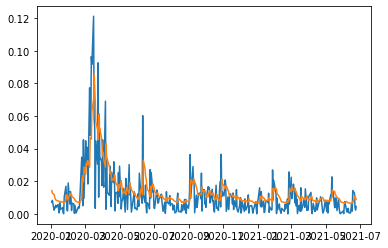

In [44]:
#visualization
plt.figure(1)
plt.rc('xtick', labelsize = 10)
plt.plot(prices.index[1:], realized)
plt.plot(prices.index[1:], conditional)
plt.show()